C:\Users\sciec\AppData\Local\Temp\ipykernel_12944\4005737158.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud['age'].fillna(fraud['age'].median(), inplace=True)
C:\Users\sciec\AppData\Local\Temp\ipykernel_12944\4005737158.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

Class distribution:
 class
0    136961
1     14151
Name: count, dtype: int64
Top countries by fraud rate:
 country
Unknown    0.093646
Name: class, dtype: float64


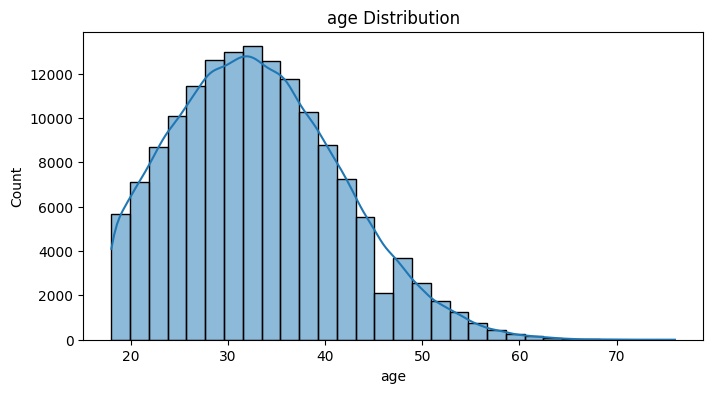

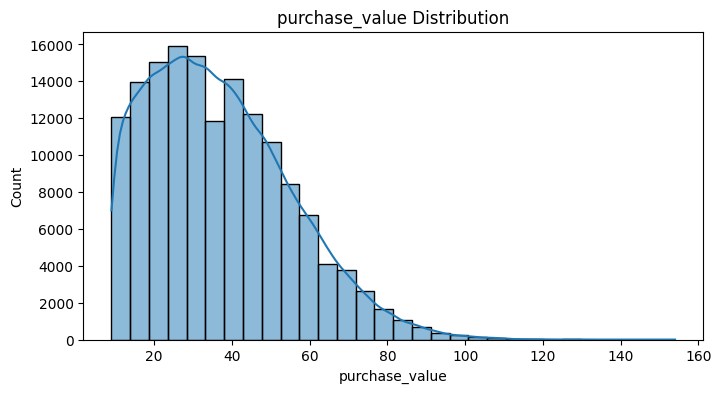

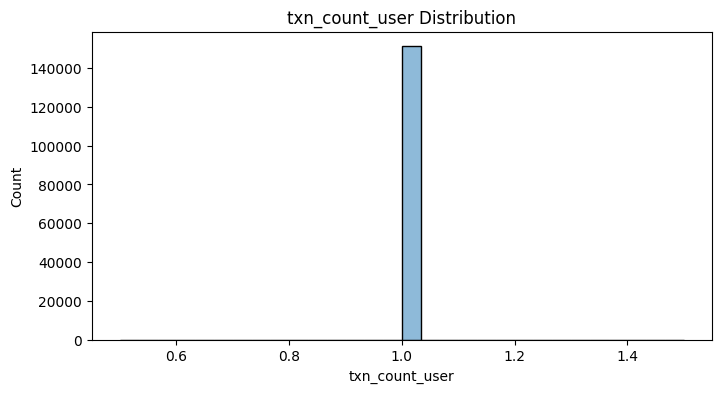

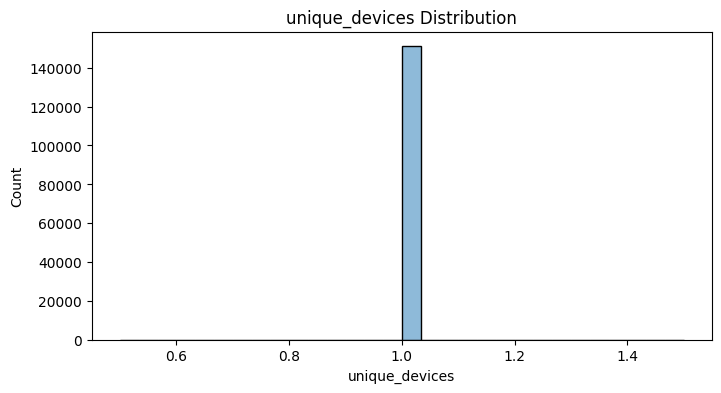

<Figure size 800x500 with 0 Axes>

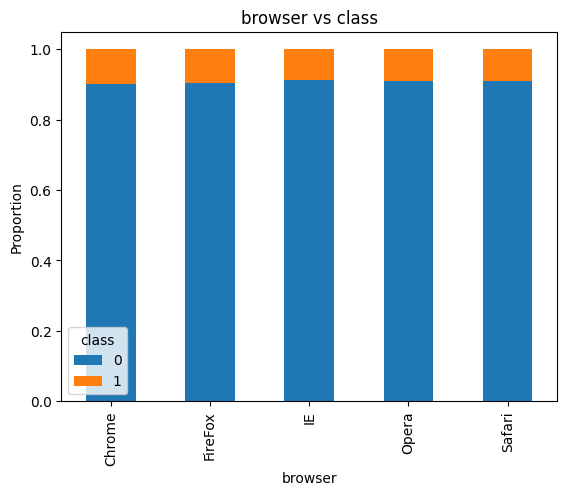

<Figure size 800x500 with 0 Axes>

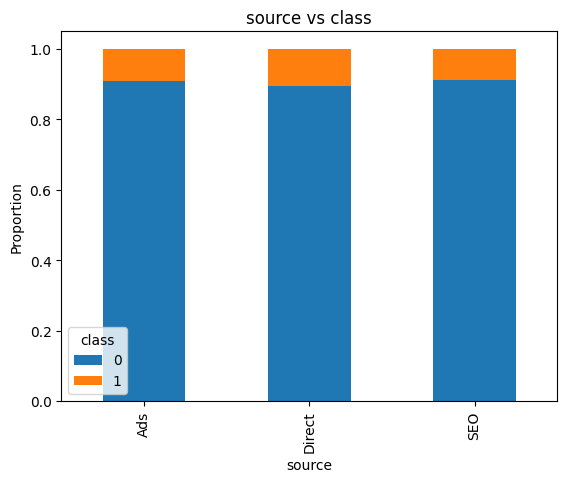

<Figure size 800x500 with 0 Axes>

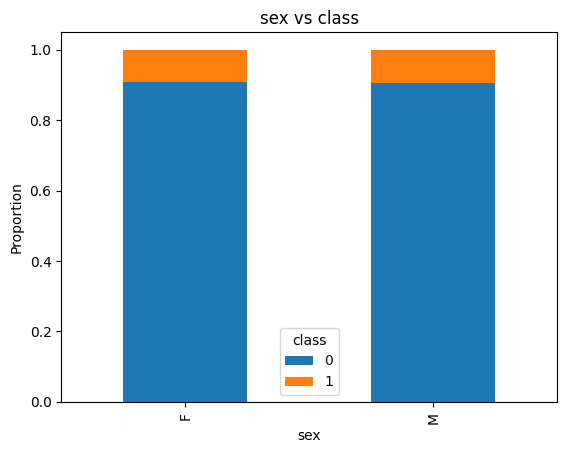

<Figure size 800x500 with 0 Axes>

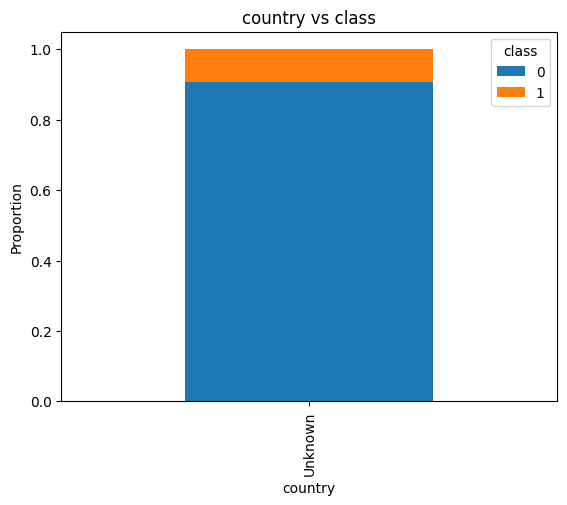

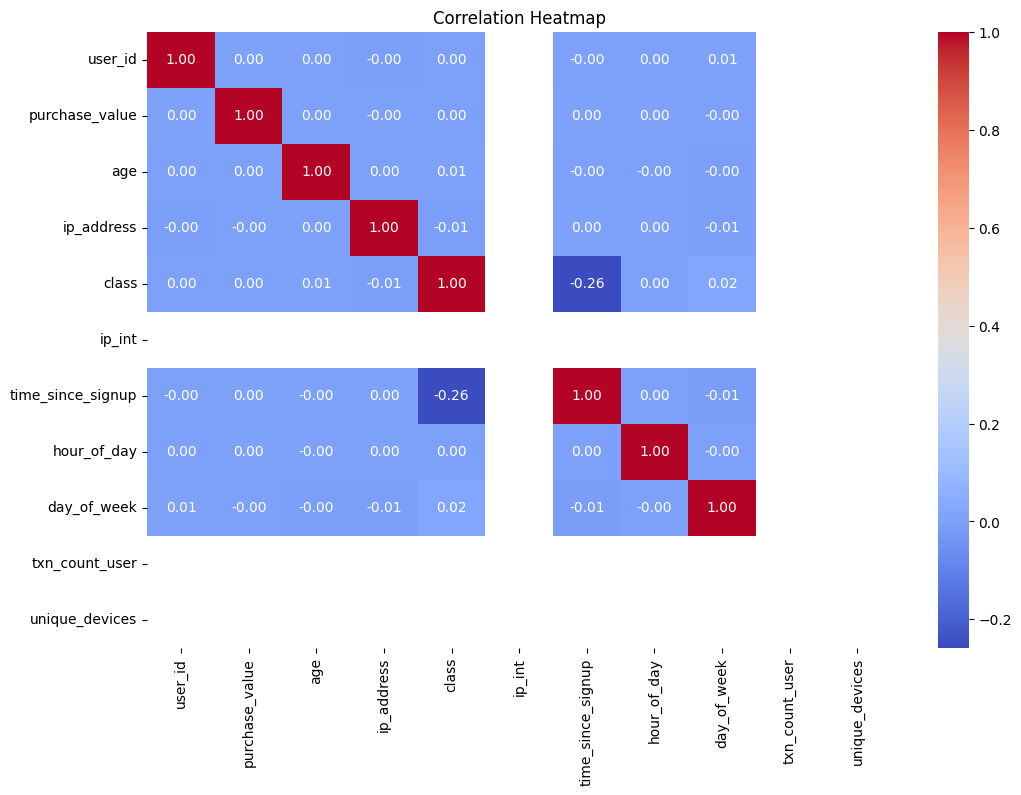

Before SMOTE: class
0    109568
1     11321
Name: count, dtype: int64
After SMOTE: class
0    109568
1    109568
Name: count, dtype: int64

✅ E-commerce data fully processed and ready!


In [4]:
# ---------------------------------------------
# Task 1 & 2: Complete EDA & Preprocessing for E-commerce
# ---------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# -------------------------------
# Helper Functions
# -------------------------------

def ip_to_int(ip):
    try:
        return sum(int(x) * 256**i for i, x in enumerate(reversed(ip.split('.'))))
    except:
        return 0

def find_country(ip, ip_country_df=None):
    if ip == 0:
        return 'Unknown'
    if ip_country_df is None:
        raise ValueError("ip_country_df must be provided")
    row = ip_country_df[(ip_country_df['lower'] <= ip) & (ip_country_df['upper'] >= ip)]
    return row['country'].values[0] if not row.empty else 'Unknown'

def plot_correlation_heatmap(df):
    numeric_df = df.select_dtypes(include='number')
    plt.figure(figsize=(12,8))
    sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

def plot_bivariate_categorical(df, cat_col, target_col='class'):
    plt.figure(figsize=(8,5))
    cross_tab = pd.crosstab(df[cat_col], df[target_col], normalize='index')
    cross_tab.plot(kind='bar', stacked=True)
    plt.title(f"{cat_col} vs {target_col}")
    plt.ylabel("Proportion")
    plt.show()

def merge_ip_country(fraud_df, ip_country_df):
    fraud_df['ip_int'] = fraud_df['ip_address'].apply(ip_to_int)
    ip_country_df['lower'] = ip_country_df['lower_bound_ip_address'].astype(int)
    ip_country_df['upper'] = ip_country_df['upper_bound_ip_address'].astype(int)
    fraud_df['country'] = fraud_df['ip_int'].apply(lambda ip: find_country(ip, ip_country_df))
    fraud_rate_country = fraud_df.groupby('country')['class'].mean().sort_values(ascending=False)
    print("Top countries by fraud rate:\n", fraud_rate_country.head(10))
    return fraud_df

def engineer_time_user_features(df):
    df['signup_time'] = pd.to_datetime(df['signup_time'])
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()
    df['hour_of_day'] = df['purchase_time'].dt.hour
    df['day_of_week'] = df['purchase_time'].dt.dayofweek
    df['txn_count_user'] = df.groupby('user_id')['user_id'].transform('count')
    df['unique_devices'] = df.groupby('user_id')['device_id'].transform('nunique')
    return df

def preprocess_and_balance(df, target='class', test_size=0.2, random_state=42):
    drop_cols = ['user_id', 'device_id', 'ip_address', 'signup_time', 'purchase_time']
    X = pd.get_dummies(df.drop(columns=[target] + drop_cols), drop_first=True)
    y = df[target]

    num_cols = ['purchase_value', 'time_since_signup', 'txn_count_user']
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    print("Before SMOTE:", y_train.value_counts())
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("After SMOTE:", y_train_res.value_counts())

    return X_train_res, X_test, y_train_res, y_test

# -------------------------------
# Load datasets
# -------------------------------
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_country = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

# -------------------------------
# Data cleaning & missing values
# -------------------------------
fraud['age'].fillna(fraud['age'].median(), inplace=True)
fraud['browser'].fillna(fraud['browser'].mode()[0], inplace=True)
fraud['source'].fillna(fraud['source'].mode()[0], inplace=True)
fraud['ip_address'].fillna('0.0.0.0', inplace=True)
fraud.drop_duplicates(inplace=True)
fraud['class'] = fraud['class'].astype(int)

print("Class distribution:\n", fraud['class'].value_counts())

# -------------------------------
# Merge IP and engineer features
# -------------------------------
fraud = merge_ip_country(fraud, ip_country)
fraud = engineer_time_user_features(fraud)

# -------------------------------
# Univariate EDA
# -------------------------------
for col in ['age', 'purchase_value', 'txn_count_user', 'unique_devices']:
    plt.figure(figsize=(8,4))
    sns.histplot(fraud[col], bins=30, kde=True)
    plt.title(f"{col} Distribution")
    plt.show()

for col in ['browser', 'source', 'sex', 'country']:
    plot_bivariate_categorical(fraud, col, 'class')

# Correlation heatmap
plot_correlation_heatmap(fraud)

# -------------------------------
# Preprocessing & SMOTE
# -------------------------------
X_train_f, X_test_f, y_train_f, y_test_f = preprocess_and_balance(fraud)

# -------------------------------
# Save processed datasets
# -------------------------------
X_train_f.to_csv("../data/processed/X_train_fraud.csv", index=False)
X_test_f.to_csv("../data/processed/X_test_fraud.csv", index=False)
y_train_f.to_csv("../data/processed/y_train_fraud.csv", index=False)
y_test_f.to_csv("../data/processed/y_test_fraud.csv", index=False)

print("\n✅ E-commerce data fully processed and ready!")
